**Table of contents**<a id='toc0_'></a>    
- 1. [Load data       ](#toc1_)    
  - 1.1. [Load LFE catalog     ](#toc1_1_)    
  - 1.2. [Load earthquake catalog      ](#toc1_2_)    
- 2. [Project tremor along strike   ](#toc2_)    
- 3. [Trim catalogs   ](#toc3_)    
- 4. [Measure earthquake tremor distance  ](#toc4_)    
- 5. [Count earthquakes "felt" by tremor       ](#toc5_)    
- 6. [Inspect results ](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [36]:
# Imports
%matplotlib widget 
import numpy as np
import pandas as pd

from scipy.spatial import cKDTree

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import os
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    workdir = '/Users/gaspard/Documents/work/'

# 1. <a id='toc1_'></a>Load data        [&#128285;](#toc0_)

In [37]:
# Constants
day0 = np.datetime64('2006-06-01')

## 1.1. <a id='toc1_1_'></a>Load LFE catalog      [&#128285;](#toc0_)

In [38]:
# Shelly catalog
# --> Load catalog
CAT_PATH = workdir + 'projects/data/Catalogs/saf_lfes/saf_lfes_shelly17_extended.txt'
COL_NAMES = [ "year", "month", "day", "s_of_day", "hour", "minute", "second", "ccsum", "meancc", 
             "med_cc", "seqday", "ID", "lat", "lon", "depth", "n_chan" ]
lfe = pd.read_csv(
    CAT_PATH,
    names=COL_NAMES,
    comment='%',
    delim_whitespace=True,
    index_col=False
    )
lfe["date"] = pd.to_datetime(lfe[["year", "month", "day", "hour", "minute", "second"]])
lfe.sort_values(by=["date"], inplace=True)

print('\nShelly LFEs')
print('{:e} LFEs, spanning {:d}--{:d}'.format(len(lfe), lfe.year.min(), lfe.year.max()))

lfe['day'] = (lfe.date - day0) / np.timedelta64(1, 'D')

# Clean and organize catalog
lfe = lfe[['date', 'lon', 'lat', 'depth', 'day', 'ID']]

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/3680034493.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  lfe = pd.read_csv(



Shelly LFEs
1.475910e+06 LFEs, spanning 2001--2022


In [39]:
# Store LFE family information in a dataframe
# First, we group the LFEs by ID, lon, lat, and depth
lfe_grouped = lfe.groupby(['ID', 'lon', 'lat', 'depth'])

# Then, we create an empty dataframe to store the results
lfe_fam = pd.DataFrame(columns=['id', 'lon', 'lat', 'depth', 'n_ev'])

# Loop over the groups and compute the episodicity for each family
for group_name, group_data in lfe_grouped:
    # Compute the number of events in the family
    n_ev = len(group_data)
    
    # Add the result to the dataframe
    lfe_fam.loc[len(lfe_fam)] = [group_name[0], group_name[1], group_name[2], group_name[3], n_ev]

## 1.2. <a id='toc1_2_'></a>Load earthquake catalog       [&#128285;](#toc0_)

In [40]:
# Load earthquakes
# --> First, base catalog
path = workdir + "projects/data/Catalogs/nocal_felix_84_24/NCAeqDD.v202112.1"

with open(path, 'r') as f:
    lines = f.readlines()

lines = lines[97:]  # remove header

year = []
month = []
day = []
hour = []
minute = []
second = []
lon = []
lat = []
depth = []
mag = []
for line in lines:
    line = line.split()
    year.append(int(line[0]))
    month.append(int(line[1]))
    day.append(int(line[2]))
    hour.append(int(line[3]))
    minute.append(int(line[4]))
    second.append(float(line[5]))
    lat.append(float(line[6]))
    lon.append(float(line[7]))
    depth.append(float(line[8]))
    mag.append(float(line[-2]))

eq_base = pd.DataFrame({'year': year, 'month': month, 'day': day, 'hour': hour, 'minute': minute, 'second': second, 'lon': lon, 'lat': lat, 'depth': depth, 'mag': mag})
eq_base['date'] = pd.to_datetime(eq_base[['year', 'month', 'day', 'hour', 'minute', 'second']])

eq_base = eq_base[['date', 'lon', 'lat', 'depth', 'mag']]

# --> Second, real-time catalog
path = workdir + "projects/data/Catalogs/nocal_felix_84_24/NCAeqDD.v202112.1.RT_0122_0824"

cols = ['year', 'month', 'day', 'hour', 'minute', 'second', 'lat', 'lon', 'depth', 'ex', 'ey', 'ez', 'mag', 'id', 'ver', 'base', 'meth']
eq_rt = pd.read_csv(path, delim_whitespace=True, names=cols, skiprows=78)   

eq_rt['date'] = pd.to_datetime(eq_rt[['year', 'month', 'day', 'hour', 'minute', 'second']])
eq_rt = eq_rt[['date', 'lon', 'lat', 'depth', 'mag']]

# --> Merge catalogs
eq = pd.concat([eq_base, eq_rt], ignore_index=True)
eq = eq.sort_values('date')

# --> Trim catalogs
after_2006 = eq['date'] >= np.datetime64('2006-06-01')

lon_min = -122.5
lon_max = -118.5
lat_min = 34.5
lat_max = 37.5
in_box = (eq['lon'] >= lon_min) & (eq['lon'] <= lon_max) & (eq['lat'] >= lat_min) & (eq['lat'] <= lat_max)

eq = eq[after_2006 & in_box]

# --> Days since 2006-06-01
eq['days'] = (eq['date'] - day0) / np.timedelta64(1, 'D')

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2068584615.py:42: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  eq_rt = pd.read_csv(path, delim_whitespace=True, names=cols, skiprows=78)


# 2. <a id='toc2_'></a>Project events along strike    [&#128285;](#toc0_)

In [41]:
# Define strike
# --> Get cartesian coordinates for everyone
crs = ccrs.TransverseMercator(central_longitude=lfe_fam.lon.mean(), central_latitude=lfe_fam.lat.mean())

lfe_coords = crs.transform_points(ccrs.PlateCarree(), lfe.lon.values, lfe.lat.values)
lfe_fam_coords = crs.transform_points(ccrs.PlateCarree(), lfe_fam.lon.values, lfe_fam.lat.values)
eq_coords = crs.transform_points(ccrs.PlateCarree(), eq.lon.values, eq.lat.values)

lfe.loc[:, 'x'] = lfe_coords[:, 0]/1000  # x is easting (km)
lfe.loc[:, 'y'] = lfe_coords[:, 1]/1000  # y is northing (km)
lfe_fam.loc[:, 'x'] = lfe_fam_coords[:, 0]/1000
lfe_fam.loc[:, 'y'] = lfe_fam_coords[:, 1]/1000 
eq.loc[:, 'x'] = eq_coords[:, 0]/1000
eq.loc[:, 'y'] = eq_coords[:, 1]/1000
  
# Define along-strike: fit a polynomial to the LFE line
p_strike = np.polyfit(lfe_fam.x, lfe_fam.y, 1)
# Project along-strike: nearest point from each event to the strike line
# --> Define a strike line with evenly spaced points along it
x0, y0 = -200, np.polyval(p_strike, -200)   # initial point
ds = .01 # spacing along the curve in km

X, Y = [], []  # initialize the location of the points along the line
X.append(x0)
Y.append(y0)
x = x0
while x < 200:
    # Using the arc-length formula, we can find the dy to the next point,
    # and then using the polynomial, we can find the corresponding x.
    dx = ds / np.sqrt(1 + (np.polyval(np.polyder(p_strike), x))**2)
    x += dx
    y = np.polyval(p_strike, x)
    X.append(x)
    Y.append(y)

S = np.cumsum(np.ones(len(X)) * ds) - ds  # along-strike distance for each (X, Y)

# --> Find nearest neighbor — but the distance matrix is huge, so make a tree of the strike points 
# to have a rough first guess before computing the nearest neighbor

tree = cKDTree(np.column_stack((X, Y)))
lfe_fam_across_strike_dist, lfe_fam_nearest_idx = tree.query(np.column_stack((lfe_fam.x, lfe_fam.y)))
eq_across_strike_dist, eq_nearest_idx = tree.query(np.column_stack((eq.x, eq.y)))

lfe_fam_along_strike_dist = S[lfe_fam_nearest_idx]
eq_along_strike_dist = S[eq_nearest_idx]

lfe_fam['xf'] = lfe_fam_along_strike_dist.max() - lfe_fam_along_strike_dist
lfe_fam['yf'] = lfe_fam_across_strike_dist

eq['xf'] = lfe_fam_along_strike_dist.max() - eq_along_strike_dist
eq['yf'] = eq_across_strike_dist

# Give each LFE the distance along-strike of its family
for id in lfe_fam.id.values:
    lfe.loc[lfe.ID == id, 'xf'] = lfe_fam.loc[lfe_fam.id == id, 'xf'].values[0]
    lfe.loc[lfe.ID == id, 'yf'] = lfe_fam.loc[lfe_fam.id == id, 'yf'].values[0]

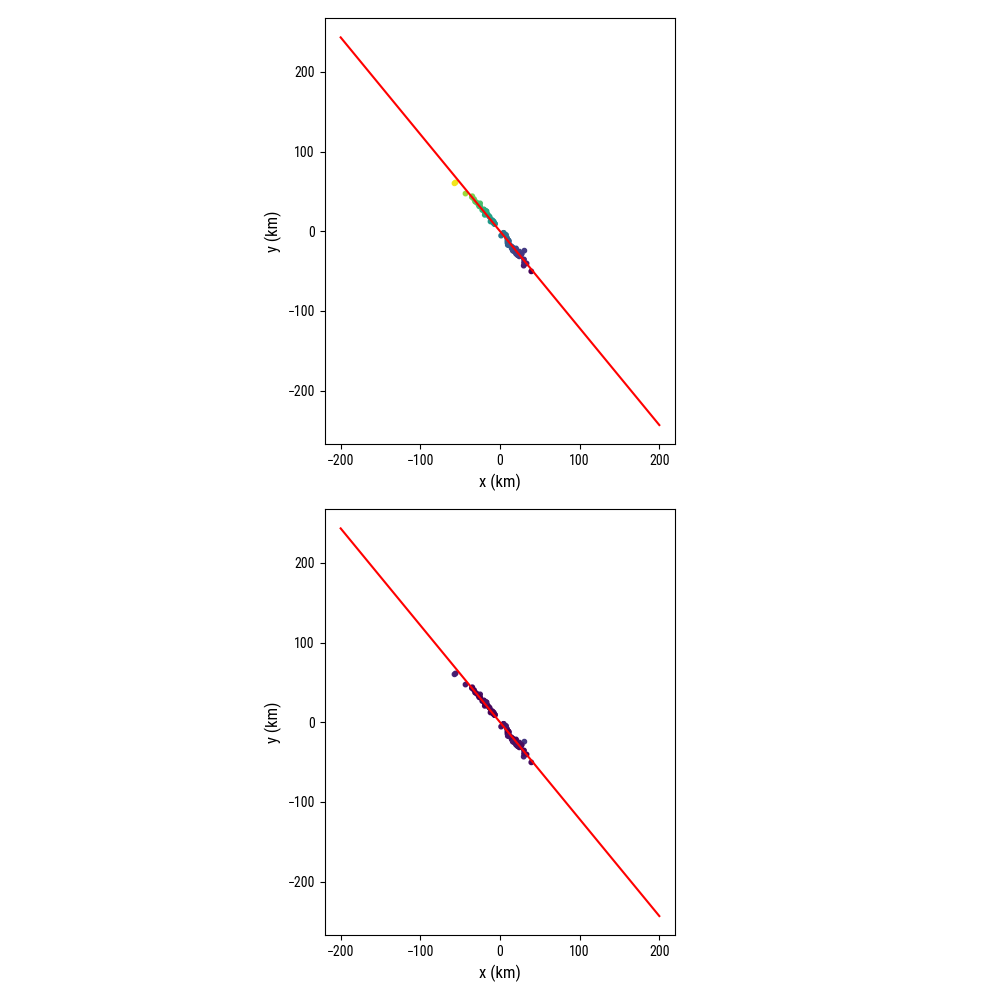

In [42]:
# Show
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
for ax in axes:
    ax.set_aspect('equal')
    ax.set_xlabel('x (km)')  
    ax.set_ylabel('y (km)')
    ax.plot(X, Y, 'r', zorder=10)

# axes[0].scatter(eq.x, eq.y, s=eq.mag**3, c=eq_along_strike_dist, ec='k', cmap='viridis', vmin=0, vmax=1500)
axes[0].scatter(lfe_fam.x, lfe_fam.y, s=10, c=lfe_fam.xf, cmap='viridis', vmin=0, vmax=150)

# axes[1].scatter(eq.x, eq.y, s=eq.mag**3, c=eq_across_strike_dist, ec='k', cmap='viridis')
axes[1].scatter(lfe_fam.x, lfe_fam.y, s=10, c=lfe_fam.yf, cmap='viridis', vmax=50)

plt.tight_layout()
plt.show()

# 3. <a id='toc3_'></a>Trim catalogs    [&#128285;](#toc0_)

In [43]:
# Trim earthquakes and LFE to same time period
print('LFEs', lfe.date.min(), lfe.date.max())
print('Earthquakes', eq.date.min(), eq.date.max())

interval = [np.datetime64('2006-06-01'), np.datetime64('2023-01-01')]
eq = eq[(eq.date.values > interval[0]) & (eq.date.values < interval[1])]
lfe = lfe[(lfe.date.values > interval[0]) & (lfe.date.values < interval[1])]

print('\nChosen interval', interval)

LFEs 2001-04-06 11:56:59.350000 2022-12-31 19:47:43.300000
Earthquakes 2006-06-01 00:10:32.596000 2024-08-06 19:04:54.120000

Chosen interval [numpy.datetime64('2006-06-01'), numpy.datetime64('2023-01-01')]


# 4. <a id='toc4_'></a>Measure earthquake LFE distance   [&#128285;](#toc0_)

In [44]:
# Measure distance between earthquakes and the nearest LFE
tree = cKDTree(np.column_stack((lfe_fam.x.values, lfe_fam.y.values, lfe_fam.depth.values)))

dist2trm, idx = tree.query(np.column_stack((eq.x, eq.y, eq.depth)))
eq['dist2trm'] = dist2trm

In [45]:
# Save processed earthquakes (trimmed, distance to tremor computed)
path = 'data/parkfield/processed/park_eq_0606_0123.csv'
print('Saving to ', path)
eq.to_csv(path, index=False)

Saving to  data/parkfield/processed/park_eq_0606_0123.csv


# 5. <a id='toc5_'></a>Count earthquakes "felt" by LFEs        [&#128285;](#toc0_)

In [46]:
# Which distance and magnitude bins
min_mags = [2.4, 2.2, 2., 1.8, 1.5, 1.]
distances = [10, 20, 30, 50, 100]

In [47]:
# Run through minimum magnitudes and distance, and compute number of earthquakes within distance of LFE

for min_mag in min_mags:
    # --> Select earthquakes
    selected_eq = eq[
        (eq.mag >= min_mag) \
        & (eq.dist2trm <= np.max(distances))
    ]
    print('Mmin =', min_mag, 'Neq =', len(selected_eq))

    # --> Make trees
    eq_tree = cKDTree(selected_eq[['x', 'y', 'depth']].values)
    trm_tree = cKDTree(lfe_fam[['x', 'y', 'depth']].values)
    
    for dist in distances:
        print('d <', dist)
        # Query LFE tree to find which earthquakes are closer than `dist`
        eq_neighbors_idxs = trm_tree.query_ball_tree(eq_tree, dist)  # a tuple of eq indices for each LFE

        # Count number of neighbors for each LFE
        n_eq_neighbors = np.array([len(e) for e in eq_neighbors_idxs])

        # Convert to number of eq neighbors per year analyzed
        n_eq_neighbors = n_eq_neighbors / ((interval[1] - interval[0]).astype('timedelta64[D]').astype(int) / 365)

        # Store information in LFE dataset
        new_key = "m{:.1f}in{:d}km".format(min_mag, dist)
        lfe_fam[new_key] = n_eq_neighbors

        # Give each LFE the distance along-strike of its family (takes most time)
        for id in lfe_fam.id.values:
            lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]

Mmin = 2.4 Neq = 3111
d < 10


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


d < 20


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


d < 30


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


d < 50


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


d < 100


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


Mmin = 2.2 Neq = 4923
d < 10


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


d < 20


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


d < 30


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


d < 50


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


d < 100


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


Mmin = 2.0 Neq = 7387
d < 10


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


d < 20


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


d < 30


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


d < 50


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


d < 100


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


Mmin = 1.8 Neq = 10792
d < 10


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


d < 20


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


d < 30


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


d < 50


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


d < 100


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


Mmin = 1.5 Neq = 17718
d < 10


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


d < 20


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


d < 30


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


d < 50


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


d < 100


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


Mmin = 1.0 Neq = 34773
d < 10


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


d < 20


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


d < 30


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


d < 50


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


d < 100


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_97468/2735843947.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfe.loc[lfe.ID == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]


In [48]:
# Save processed LFE dataset
path = 'data/parkfield/processed/park_lfe_0606_0123.csv'
print('Saving at', path)
lfe.to_csv(path, index=False)

# Also save families
lfe_fam.to_csv('data/parkfield/processed/park_lfe_fam_0606_0123.csv', index=False)

Saving at data/parkfield/processed/park_lfe_0606_0123.csv


# 6. <a id='toc6_'></a>Inspect results  [&#128285;](#toc0_)

In [49]:
# Load processed results
lfe_fam = pd.read_csv('data/parkfield/processed/park_lfe_fam_0606_0123.csv')
lfe = pd.read_csv('data/parkfield/processed/park_lfe_0606_0123.csv')
eq = pd.read_csv('data/parkfield/processed/park_eq_0606_0123.csv')

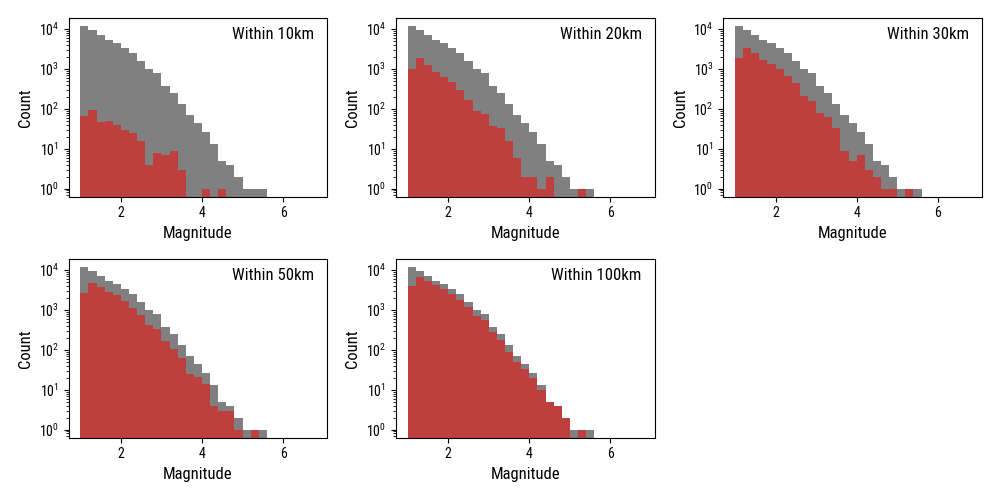

In [50]:
# Magnitude of completeness for each distance

fig, axes = plt.subplots(2, 3, figsize=(10, 5))

for ii in range(6):
    if ii == 5: axes[ii//3, ii%3].remove() ; continue
    ax = axes[ii//3, ii%3]
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Count')
    ax.set_yscale('log')
    ax.text(.95, .95, 'Within {:d}km'.format(distances[ii]), va='top', ha='right', transform=ax.transAxes)

    ax.hist(eq.mag.values, bins=np.arange(1, 7, .2), fc='gray', ec='none')
    ax.hist(eq.mag[(eq.mag > 1) & (eq.dist2trm < distances[ii])].values, bins=np.arange(1, 7, .2), fc=to_rgba('r', .5), ec='none')

plt.tight_layout()
plt.show()

In [51]:
# Which distance/minimum magnitude for maps
min_mag = 2.2

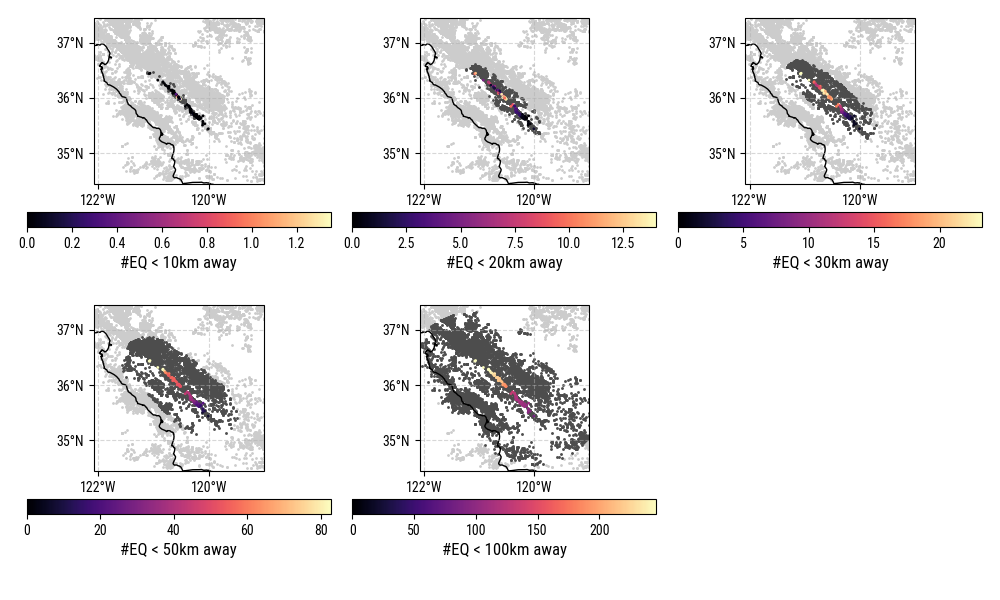

In [52]:
# Maps
lon_min = lfe_fam.lon.min() - 1
lon_max = lfe_fam.lon.max() + 1
lat_min = lfe_fam.lat.min() - 1
lat_max = lfe_fam.lat.max() + 1
crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(10, 6))
axes = [plt.subplot(2, 3, ii+1, projection=crs) for ii in range(5)]

for ii, ax in zip(range(len(distances)), np.array(axes).flatten()):
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
    ax.coastlines(lw=1)

    # Plot tremor
    sc = ax.scatter(lfe_fam.lon, lfe_fam.lat, c=lfe_fam['m{:.1f}in{:d}km'.format(min_mag, distances[ii])], s=1, cmap='magma', transform=crs, vmin=0, vmax=np.percentile(lfe_fam['m{:.1f}in{:d}km'.format(min_mag, distances[ii])], 95), zorder=2, label='Tremor')
    ax.scatter(eq[eq.dist2trm < distances[ii]].lon, eq[eq.dist2trm < distances[ii]].lat, c='.3', s=1, transform=crs, zorder=1, label='Earthquakes in range'.format(distances[ii]))
    ax.scatter(eq.lon, eq.lat, c='.8', s=1, transform=crs, zorder=0, label='All earthquakes')

    # Colorbar
    x_min_ax = 0.5; y_min_ax = -0.2
    w_ax = 0.45; h_ax = 0.05
    x_max_ax = x_min_ax + w_ax; y_max_ax = y_min_ax + h_ax

    cbar = plt.colorbar(sc, orientation='horizontal', label="#EQ < {:d}km away".format(distances[ii]), fraction=0.3, pad=0.1)

    # grid and labels, only bottom and left, not top and right
    ax.set_xticks(np.arange(np.ceil(lon_min), lon_max+1, 2), crs=crs)
    ax.set_yticks(np.arange(np.ceil(lat_min), lat_max, 1), crs=crs)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()